In [1]:
import atlite
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import os
import numpy as np
import pandas as pd

In [33]:
import os
import pandas as pd 
import numpy as np
import geopandas as gpd

from pyproj import Transformer
from pyproj import CRS, Proj

from osgeo import gdal 
import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import Point
import matplotlib.pyplot as plt


import xarray as xr
import geopy.distance
import pickle
from scipy.constants import physical_constants

# Creating Zone Profiles

In [4]:
runoff = xr.open_dataarray("Cutouts_atlite/Laos5AVG_Runoff.nc")

In [7]:
gdf_25 = gpd.read_file("Data_25\hydropower_dams_25.gpkg")
gdf_30 = gpd.read_file("Data_30\hydropower_dams_30.gpkg")

gdf_areas = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-prep-Laos\Raw_Spatial_Data\areas_laos.geojson')


In [10]:
def assign_zones_to_plants(plants_gdf, areas_gdf, zone_column="Area_new24"):
    """
    Assign zones to hydropower plants based on their spatial location.

    Args:
        plants_gdf (GeoDataFrame): GeoDataFrame containing hydropower plant locations.
        areas_gdf (GeoDataFrame): GeoDataFrame containing zone polygons with the `zone_column`.
        zone_column (str): Column name in `areas_gdf` representing zones.

    Returns:
        GeoDataFrame: Updated plants GeoDataFrame with assigned zones.
    """
    # Ensure both GeoDataFrames have the same CRS
    plants_gdf = plants_gdf.to_crs(areas_gdf.crs)

    # Perform spatial join to assign zones
    plants_with_zones = gpd.sjoin(plants_gdf, areas_gdf[[zone_column, "geometry"]], how="left", op="intersects")

    # Drop duplicate geometry columns if any
    plants_with_zones = plants_with_zones.drop(columns=["index_right"])

    return plants_with_zones


In [12]:
# Load spatial data
plants_gdf = gdf_30  # Replace with gdf30 if needed
# Step 1: Assign zones to plants
plants_with_zones = assign_zones_to_plants(plants_gdf, gdf_areas)


c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
def load_and_process_load_profiles(excel_path, sheets, monthly_columns, hours_in_month):
    """
    Load and process load profiles from an Excel file for each zone.

    Args:
        excel_path (str): Path to the Excel file containing load profiles.
        sheets (dict): Mapping of zone names to sheet names in the Excel file.
        monthly_columns (list): List of columns representing months.
        hours_in_month (dict): Dictionary mapping months to the number of hours.

    Returns:
        dict: A dictionary mapping zone names to expanded hourly load profiles (pd.Series).
    """
    zone_profiles = {}

    for zone, sheet in sheets.items():
        # Load the sheet
        zone_data = pd.read_excel(excel_path, sheet_name=sheet, index_col=0)

        # Expand the daily profile for each month
        hourly_demand = []
        for month_idx, hours in enumerate(hours_in_month.values()):
            avg_day_profile = zone_data.iloc[month_idx,:]  # Get daily values for the month
            expanded_monthly_profile = list(avg_day_profile) * (hours // 24)
            hourly_demand.extend(expanded_monthly_profile)

        # Create a Series with the hourly demand
        hourly_demand_series = pd.Series(
            hourly_demand,
            index=pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")
        )

        # Store the Series in the dictionary
        zone_profiles[zone] = hourly_demand_series

    return zone_profiles


In [18]:
# File path and sheet mappings
excel_path = r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-prep-Laos\Raw_Spatial_Data\Load_profile.xlsx'
sheets = {
    'north': 'TimeSlices_Northern',
    'centre': 'TimeSlices_Central',
    'south': 'TimeSlices_Southern'
}
monthly_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours_in_month = {
    'Jan': 744, 'Feb': 672, 'Mar': 744, 'Apr': 720,
    'May': 744, 'Jun': 720, 'Jul': 744, 'Aug': 744,
    'Sep': 720, 'Oct': 744, 'Nov': 720, 'Dec': 744
}

# Load and process load profiles
zone_profiles = load_and_process_load_profiles(
    excel_path=excel_path,
    sheets=sheets,
    monthly_columns=monthly_columns,
    hours_in_month=hours_in_month
) 

C:\Users\ls2823\AppData\Local\Temp\ipykernel_5300\1294102316.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")
C:\Users\ls2823\AppData\Local\Temp\ipykernel_5300\1294102316.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")
C:\Users\ls2823\AppData\Local\Temp\ipykernel_5300\1294102316.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")


In [25]:
with open("Parameters/zone_profiles.pkl", "wb") as f:
    pickle.dump(zone_profiles, f)

# Creating Net Generation

In [28]:
zone_profiles

{'north': 2023-01-01 00:00:00    402.723445
 2023-01-01 01:00:00    397.679541
 2023-01-01 02:00:00    395.916147
 2023-01-01 03:00:00    395.291711
 2023-01-01 04:00:00    400.789635
                           ...    
 2023-12-31 19:00:00    491.871710
 2023-12-31 20:00:00    461.588387
 2023-12-31 21:00:00    439.760548
 2023-12-31 22:00:00    421.374226
 2023-12-31 23:00:00    411.827935
 Freq: h, Length: 8760, dtype: float64,
 'centre': 2023-01-01 00:00:00    278.242430
 2023-01-01 01:00:00    273.790817
 2023-01-01 02:00:00    270.125301
 2023-01-01 03:00:00    270.435978
 2023-01-01 04:00:00    276.805839
                           ...    
 2023-12-31 19:00:00    472.000075
 2023-12-31 20:00:00    439.763115
 2023-12-31 21:00:00    406.090207
 2023-12-31 22:00:00    374.788070
 2023-12-31 23:00:00    361.945211
 Freq: h, Length: 8760, dtype: float64,
 'south': 2023-01-01 00:00:00    58.547097
 2023-01-01 01:00:00    58.108065
 2023-01-01 02:00:00    57.756452
 2023-01-01 03:00:00

In [20]:
def distribute_and_subtract_demand_v2(hourly_generation, zone_profiles, plants_data, zone_column):
    """
    Distribute zone-specific hourly demand across plants within each zone,
    and subtract demand from the plants' generation using dynamic hourly capacity.

    Args:
        hourly_generation (pd.DataFrame): Hourly generation values for all plants (time x plants).
        zone_profiles (dict): Dictionary mapping zones to their expanded hourly load profiles.
        plants_data (GeoDataFrame): Plant data containing assigned zones.
        zone_column (str): Column name indicating plant zone ('north', 'centre', 'south').

    Returns:
        pd.DataFrame: Net hourly generation values (time x plants).
    """
    # Initialize a DataFrame to store net generation
    net_generation = hourly_generation.copy()

    # Iterate over each zone
    for zone, hourly_zone_demand in zone_profiles.items():
        # Filter plants belonging to the current zone
        plants_in_zone = plants_data[plants_data[zone_column] == zone]
        zone_plant_names = plants_in_zone['name']

        # If no plants in this zone, skip it
        if zone_plant_names.empty:
            continue

        # Extract hourly generation for the plants in the current zone
        zone_hourly_generation = hourly_generation[zone_plant_names]

        # Calculate the total hourly generation for the zone
        total_hourly_generation = zone_hourly_generation.sum(axis=1)

        # Avoid division by zero: replace zeros with NaN temporarily
        total_hourly_generation.replace(0, float('nan'), inplace=True)

        # Distribute demand among plants in the zone based on their hourly generation
        for plant in zone_plant_names:
            # Fractional demand based on hourly generation share
            fractional_demand = (
                (zone_hourly_generation[plant] / total_hourly_generation) * hourly_zone_demand
            )

            # Fill NaN values in fractional_demand with 0 (for cases where total_hourly_generation was 0)
            fractional_demand.fillna(0, inplace=True)

            # Subtract demand from the plant's generation
            net_generation[plant] -= fractional_demand

    return net_generation


In [ ]:
net_generation_wet = distribute_and_subtract_demand_v2(
    hourly_generation=hourly_values_wet,  # Hourly generation DataFrame
    zone_profiles=zone_profiles,         # Zone-specific hourly demand profiles
    plants_data=plants_with_zones,       # Plant data with zones
    zone_column="Area_new24"             # Zone column name
)

In [21]:
def plot_net_generation(net_generation, plants_data, zone_column, max_hours=None):
    """
    Plot the net generation over time for each zone with an optional hour limit.

    Args:
        net_generation (pd.DataFrame): Net hourly generation values (time x plants).
        plants_data (GeoDataFrame): Plant data containing assigned zones.
        zone_column (str): Column name indicating plant zone ('north', 'centre', 'south').
        max_hours (int, optional): Maximum number of hours to display. Defaults to None (show all hours).

    Returns:
        None
    """
    # Limit the data to the first `max_hours` if specified
    if max_hours:
        net_generation = net_generation.iloc[:max_hours]

    # Create an hour index (1 to total hours in net_generation)
    hour_index = range(1, len(net_generation) + 1)

    # Group plants by zone
    zones = plants_data[zone_column].unique()

    plt.figure(figsize=(12, 6))

    for zone in zones:
        # Get plants in this zone
        plants_in_zone = plants_data[plants_data[zone_column] == zone]['name']

        # Aggregate net generation for the zone
        zone_net_generation = net_generation[plants_in_zone].sum(axis=1)

        # Plot the zone's net generation
        plt.plot(hour_index, zone_net_generation, label=f"{zone.capitalize()} Zone")

    # Customize the plot
    plt.title(f"Net Generation Over Hours by Zone ({'All Hours' if not max_hours else f'First {max_hours} Hours'})")
    plt.xlabel("Hour")
    plt.ylabel("Net Generation (MW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Plot only the first 1000 hours
plot_net_generation(
    net_generation=net_generation_wet,
    plants_data=plants_with_zones,
    zone_column="Area_new24",
    # max_hours=700
)

NameError: name 'net_generation_wet' is not defined

## In the Optimisation

In [56]:

def hydropower_potential(eta,flowrate,head):
    '''
    Calculate hydropower potential in Megawatts

    Parameters
    ----------
    eta : float
        Efficiency of the hydropower plant.
    flowrate : float
        Flowrate calculated with runoff multiplied by the hydro-basin area, in cubic meters per hour.
    head : float
        Height difference at the hydropower site, in meters.

    Returns
    -------
    float
        Hydropower potential in Megawatts (MW).
    '''
    rho = 997 # kg/m3; Density of water
    g = physical_constants['standard acceleration of gravity'][0] # m/s2; Based on the CODATA constants 2018
    Q = (flowrate/(1000/24)) / 3600 # transform flowrate per h into flowrate per second
    return (eta * rho * g * Q * head) / (1000 * 1000) # MW

def hydropower_potential_with_capacity(flowrate, head, capacity, eta):
    '''
    Calculate the hydropower potential considering the capacity limit

    Parameters
    ----------
    flowrate : float
        Flowrate calculated with runoff multiplied by the hydro-basin area, in cubic meters per hour.
    head : float
        Height difference at the hydropower site, in meters.
    capacity : float
        Maximum hydropower capacity in Megawatts (MW).
    eta : float
        Efficiency of the hydropower plant.

    Returns
    -------
    xarray DataArray
        Capacity factor, which is the limited potential divided by the capacity.
    '''
    potential = hydropower_potential(flowrate, head, eta)
    limited_potential = xr.where(potential > capacity, capacity, potential)
    capacity_factor = limited_potential / capacity
    return capacity_factor


In [57]:
# location_hydro = gpd.read_file(f'Data_25/hydropower_dams_25.gpkg')
# location_hydro.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
# location_hydro.rename(columns={'head_example':'head'},inplace=True)

# location_hydro['geometry'] = gpd.points_from_xy(location_hydro.lon, location_hydro.lat)
# --->>>>
# USE PLANTS_WITH_ZONES


# laos_hydrobasins = gpd.read_file('Data_hydrobasins/hydrobasins_lvl10/hybas_as_lev10_v1c.shp')
# laos_hydrobasins['lat'] = location_hydro.geometry.y
# laos_hydrobasins['lon'] = location_hydro.geometry.x

hexagons = gpd.read_file(f'Parameters_PEM_25/hex_transport.geojson')

runoff = xr.open_dataarray("Cutouts_atlite/Laos5AVG_Runoff.nc")


In [58]:
with open("Parameters/zone_profiles.pkl", "rb") as f:
    zone_profiles = pickle.load(f)

In [60]:
eta = 0.75  # efficiency of hydropower plant

# Calculate the capacity factor
capacity_factor = xr.apply_ufunc(
    hydropower_potential_with_capacity,
    runoff,
    xr.DataArray(location_hydro['head'].values, dims=['plant']),
    xr.DataArray(location_hydro['Total capacity (MW)'].values, dims=['plant']),
    eta,
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

# Rename existing 'index_left' and 'index_right' columns if they exist
if 'index_left' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_right': 'index_right_renamed'})
if 'index_left' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_right': 'index_right_renamed'})

# Map plants to hexagons
hydro_hex_mapping = gpd.sjoin(location_hydro, hexagons, how='left', predicate='within')
hydro_hex_mapping['plant_index'] = hydro_hex_mapping.index

num_hexagons = len(hexagons)
num_time_steps = len(capacity_factor.time)


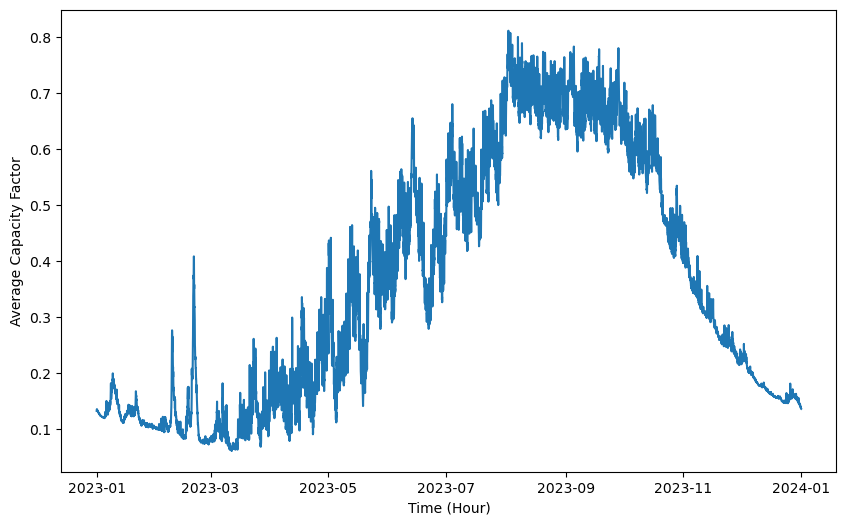

In [61]:
hourly_average = capacity_factor.mean(dim='plant')
plt.figure(figsize=(10, 6))
plt.plot(hourly_average['time'], hourly_average.values)
plt.xlabel('Time (Hour)')
plt.ylabel('Average Capacity Factor')
plt.show()

In [62]:

# Initialize the output profile
hydro_profile = xr.DataArray(
    data=np.zeros((num_hexagons, num_time_steps)),
    dims=['hexagon', 'time'],
    coords={'hexagon': np.arange(num_hexagons), 'time': capacity_factor.time}
)

# Prepare zone-specific demand for subtraction
zone_demand = pd.DataFrame(zone_profiles)


In [45]:
# location_hydro
# USE PLANTS_WITH_ZONES

In [63]:
for hex_index in range(num_hexagons):
    # Get plants in this hexagon
    plants_in_hex = hydro_hex_mapping[hydro_hex_mapping['index_right'] == hex_index]['plant_index'].tolist()
    if len(plants_in_hex) > 0:
        # Select capacity factor and plant capacities for this hexagon
        hex_capacity_factor = capacity_factor.sel(plant=plants_in_hex)
        plant_capacities = xr.DataArray(plants_with_zones.loc[plants_in_hex]['Domestic Capacity (MW)'].values, dims=['plant'])
        
        # Calculate absolute generation (MW) from capacity factor
        absolute_generation = hex_capacity_factor * plant_capacities
        
        # Subtract distributed demand for these plants
        for plant_idx, plant in enumerate(plants_in_hex):
            zone = plants_with_zones.loc[plant, 'Area_new24']  # Zone of the plant
            plant_demand = zone_demand[zone].values  # Get demand for the zone
            absolute_generation[plant_idx] -= plant_demand  # Subtract demand

        # Ensure no negative generation (set to zero where necessary)
        absolute_generation = xr.where(absolute_generation < 0, 0, absolute_generation)

        # Recalculate the net capacity factor
        net_capacity_factor = absolute_generation / plant_capacities

        # Compute weighted average capacity factor for hexagon
        weights = plant_capacities / plant_capacities.sum()
        weighted_avg_capacity_factor = (net_capacity_factor * weights).sum(dim='plant')
        hydro_profile.loc[hex_index] = weighted_avg_capacity_factor


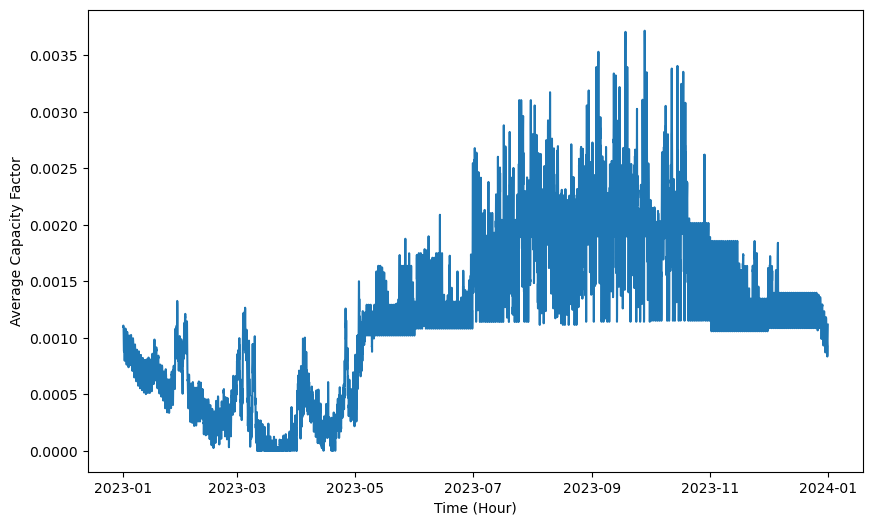

In [65]:
hourly_average = hydro_profile.mean(dim='hexagon')
plt.figure(figsize=(10, 6))
plt.plot(hourly_average['time'], hourly_average.values)
plt.xlabel('Time (Hour)')
plt.ylabel('Average Capacity Factor')
plt.show()

### OLD Code

In [ ]:

eta = 0.75 # efficiency of hydropower plant

capacity_factor = xr.apply_ufunc(
    hydropower_potential_with_capacity,
    runoff,
    xr.DataArray(location_hydro['head'].values, dims=['plant']),
    xr.DataArray(location_hydro['Total capacity (MW)'].values, dims=['plant']), # Take total capacity to calculate the capacity factor, but domestic to multiply in Hexagons
    eta,
    vectorize=True,
    dask='parallelized',  # Dask for parallel computation
    output_dtypes=[float]
)

location_hydro['geometry'] = gpd.points_from_xy(location_hydro.lon, location_hydro.lat)


# Rename existing 'index_left' and 'index_right' columns if they exist
if 'index_left' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_right': 'index_right_renamed'})
if 'index_left' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_right': 'index_right_renamed'})

hydro_hex_mapping = gpd.sjoin(location_hydro, hexagons, how='left', predicate='within')
hydro_hex_mapping['plant_index'] = hydro_hex_mapping.index
num_hexagons = len(hexagons)
num_time_steps = len(capacity_factor.time)

hydro_profile = xr.DataArray(
    data=np.zeros((num_hexagons, num_time_steps)),
    dims=['hexagon', 'time'],
    coords={'hexagon': np.arange(num_hexagons), 'time': capacity_factor.time}
)

for hex_index in range(num_hexagons):
    plants_in_hex = hydro_hex_mapping[hydro_hex_mapping['index_right'] == hex_index]['plant_index'].tolist()
    if len(plants_in_hex) > 0:
        hex_capacity_factor = capacity_factor.sel(plant=plants_in_hex)
        plant_capacities = xr.DataArray(location_hydro.loc[plants_in_hex]['Domestic Capacity (MW)'].values, dims=['plant'])

        weights = plant_capacities / plant_capacities.sum()
        weighted_avg_capacity_factor = (hex_capacity_factor * weights).sum(dim='plant')
        hydro_profile.loc[hex_index] = weighted_avg_capacity_factor